<font size="+3"><strong>Housing Price Predictor for Buenos Aires 🇦🇷</strong></font>

<font size="+2"><strong>Part 3: Predicting Housing Price with Neighborhood</strong></font>

In [27]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

This project builds on my `Predicting Housing Price with Size` and `Predicting Housing Price with Location` projects. And in the `Predicting Housing Price with Location` project, I created a model that used location — represented by latitude and longitude — to predict price. In this project, I'm going to use a different representation for location: neighborhood. 

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from glob import glob
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

GOALS
 - Build a model to predict apartment price based on neighborhood
 - Encode categorical data to train linear model
 - Battle overfitting using regularization

Machine Learning Workflow
 - Prepare Data
     - Import: wrangle function & for loop
     - Explore: Extract neighborhood from string
     - Split
 - Build Model
     - Baseline
     - Iterate: One-Hot Encoding
     - Evaluate: Overfitting
 - Communicate Results
     - Curse of Dimensionality
     - Regularization: Ridge Regression
     - Bar Charts for Coefficients

# Prepare Data

## Import

In [29]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    return df

In the `Predicting Housing Price with Size` & `Predicting Housing Price with Location`  projects, I used my `wrangle` function to import two CSV files as DataFrames. And since I'm working with multiple CSV files to import in this project, I will instead use glob where I can read several CSV files into a single DataFrame. 

The first step is to gather the names of all the files I want to import. I can do this using pattern matching. 

**Collect File Names**

In [30]:
# Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSVs
files = glob("data/buenos-aires-real-estate-*.csv") # Assign this list to the variable name files
files

['data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv']

In [31]:
len(files)

5

The next step is to read each of the CSVs in `files` into a DataFrame, and put all of those DataFrames into a list. A `for` loop is a good way to iterate through `files`.

**Wrangle With for Loop**

In [32]:
frames = [] # Create an empty list called frames
for file in files:
    print(file)

data/buenos-aires-real-estate-3.csv
data/buenos-aires-real-estate-2.csv
data/buenos-aires-real-estate-1.csv
data/buenos-aires-real-estate-5.csv
data/buenos-aires-real-estate-4.csv


As I iterate through this for loop, it goes through one by one (all of the file names above). And I want to read those files into a DataFrame.

In [33]:
frames = [] 
for file in files:
    df = wrangle(file)
    print(df.shape)

(1288, 17)
(1315, 17)
(1343, 17)
(1331, 17)
(1305, 17)


In [34]:
frames = [] 
for file in files:
    df = wrangle(file)
    frames.append(df)

In [35]:
len(frames)

5

In [36]:
type(frames[0])

pandas.core.frame.DataFrame

In [37]:
frames[0].head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
7,sell,apartment,|Argentina|Capital Federal|Villa General Mitre|,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506
20,sell,apartment,|Argentina|Capital Federal|Palermo|,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927
21,sell,apartment,|Argentina|Capital Federal|Saavedra|,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644
41,sell,apartment,|Argentina|Capital Federal|Villa del Parque|,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625
43,sell,apartment,|Argentina|Capital Federal|Belgrano|,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357


The final step is to use pandas to combine all the DataFrames in `frames`. 

**Concatenate DataFrames**

In [38]:
# Use pd.concat to concatenate the items in frames into a single DataFrame df
df = pd.concat(frames, ignore_index=True) # Set the ignore_index argument to True
df.head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Argentina|Capital Federal|Villa General Mitre|,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506
1,sell,apartment,|Argentina|Capital Federal|Palermo|,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927
2,sell,apartment,|Argentina|Capital Federal|Saavedra|,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644
3,sell,apartment,|Argentina|Capital Federal|Villa del Parque|,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625
4,sell,apartment,|Argentina|Capital Federal|Belgrano|,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357


In [39]:
df.shape

(6582, 17)

## Explore

Looking through the output from the `df.head()` call above, there's a little bit more cleaning I need to do before I can work with the neighborhood information in this dataset. 

Since I'm using a `wrangle` function, I only need to change the function to re-clean all of my CSV files. Hence why functions are so useful.

**Create "Neighborhood" Feature**

In [40]:
# Find the neighborhood for each property in the "place_with_parent_names" column
df["place_with_parent_names"].head()

0    |Argentina|Capital Federal|Villa General Mitre|
1                |Argentina|Capital Federal|Palermo|
2               |Argentina|Capital Federal|Saavedra|
3       |Argentina|Capital Federal|Villa del Parque|
4               |Argentina|Capital Federal|Belgrano|
Name: place_with_parent_names, dtype: object

In [41]:
df["place_with_parent_names"].str.split("|").head()

0    [, Argentina, Capital Federal, Villa General M...
1            [, Argentina, Capital Federal, Palermo, ]
2           [, Argentina, Capital Federal, Saavedra, ]
3    [, Argentina, Capital Federal, Villa del Parqu...
4           [, Argentina, Capital Federal, Belgrano, ]
Name: place_with_parent_names, dtype: object

In [42]:
df["place_with_parent_names"].str.split("|", expand=True).head()

,0,1,2,3,4
0,,Argentina,Capital Federal,Villa General Mitre,
1,,Argentina,Capital Federal,Palermo,
2,,Argentina,Capital Federal,Saavedra,
3,,Argentina,Capital Federal,Villa del Parque,
4,,Argentina,Capital Federal,Belgrano,


In [43]:
df["place_with_parent_names"].str.split("|", expand=True)[3].head()

0    Villa General Mitre
1                Palermo
2               Saavedra
3       Villa del Parque
4               Belgrano
Name: 3, dtype: object

In [44]:
# Modify the wrangle function to create a new feature "neighborhood"

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    return df

In [45]:
frames = [] 
for file in files:
    df = wrangle(file)
    frames.append(df)

In [46]:
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
1,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
2,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
3,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
4,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


## Split

 I can condense the whole process (splitting data) down to one task.

**Split Data**

In [47]:
# Create feature matrix X_train and target vector y_train
target = "price_aprox_usd" # target is "price_aprox_usd"
features = ["neighborhood"] # X_train should contain one feature: "neighborhood"
y_train = df[target]
X_train = df[features]

# Build Model

I can condense the code I use to establish my baseline.

**Baseline Model**

In [48]:
# Calculate the baseline mean absolute error for my model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


The mean apartment price and baseline MAE should be similar but not identical to one in `Predicting Housing Price with Location`project. This is because numbers change since I'm working with more data.

## Iterate

If I try to fit a `LinearRegression` predictor to my training data at this point, I'll get an error that says "ValueError: could not convert string to float".

When I fit a linear regression model, I'm asking scikit-learn to perform a mathematical operation. The problem is that my training set contains neighborhood information in a non-numerical form.

In order to create my model I need to **encode** that information so that it's represented numerically. There are lots of transformers that can do this and for this project, I'll be using one from the [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) library, called a [`OneHotEncoder`](https://contrib.scikit-learn.org/category_encoders/onehot.html).

**Transformer: OneHotEncoder**

In [49]:
X_train.head()

,neighborhood
0,Villa General Mitre
1,Palermo
2,Saavedra
3,Villa del Parque
4,Belgrano


In [ ]:
# If I try to fit a LinearRegression predictor to my training data at this point, I'll get an error
model = LinearRegression()
model.fit(X_train, y_train)

In [50]:
# Instantiate a OneHotEncoder named ohe
ohe = OneHotEncoder(use_cat_names=True)

# Fit
ohe.fit(X_train)

# Transform
XT_train= ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Villa General Mitre,neighborhood_Palermo,neighborhood_Saavedra,neighborhood_Villa del Parque,neighborhood_Belgrano,neighborhood_Coghlan,neighborhood_Chacarita,neighborhood_Boedo,neighborhood_Caballito,neighborhood_Monserrat,...,neighborhood_Versalles,neighborhood_Villa Lugano,neighborhood_Parque Avellaneda,neighborhood_Las Cañitas,neighborhood_Villa Soldati,neighborhood_Parque Chas,neighborhood_Velez Sarsfield,neighborhood_Pompeya,neighborhood_Villa Real,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Build Model**

In [51]:
# Create a pipeline named model that contains a OneHotEncoder transformer and a LinearRegression predictor
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)

model.fit(X_train, y_train) # Fit my model to the training data

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [52]:
# Check my work
check_is_fitted(model[-1])

Above, I built a model with two transformers and a predictor.

## Evaluate

Regardless of how I build my model, the evaluation step stays the same. I'll see how my model performs with the training set.

**Training Mean Absolute Error**

In [53]:
# Create a list of predictions for the observations in the feature matrix X_train
y_pred_training = model.predict(X_train) # Name this list y_pred_training

# Calculate the training mean absolute error for the predictions in y_pred_training as compared to the true targets in y_train
mae_training = mean_absolute_error(y_train, y_pred_training) 
print("Training MAE:", round(mae_training, 2))

Training MAE: 39337.76


In [54]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [55]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


In [56]:
# Import test data "buenos-aires-test-features.csv" into a DataFrame
X_test = pd.read_csv("data/buenos-aires-test-features.csv")[features]

# Generate a Series of predictions using my model
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

# Communicate Results

If I write out the equation for my model, it'll be too big to fit on the screen. That's because, when I used the `OneHotEncoder` to encode the neighborhood data, I created a much wider DataFrame, and each column/feature has it's own coefficient in my model's equation.

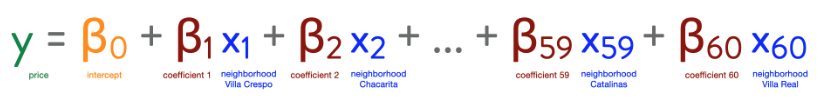

This is important to keep in mind for two reasons. First, it means that this is a **high-dimensional** model. Instead of a 2D or 3D plot, I'd need a 58-dimensional plot to represent it, which is impossible. Second, it means that I'll need to extract and represent the information for my equation a little differently than before. I'll start by getting my intercept and coefficient.

**Extract Coefficients**

In [57]:
# Extract coefficients for my model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [58]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[2.73010108e+16 2.73010108e+16 2.73010108e+16 2.73010108e+16
 2.73010108e+16]


I have the values of my coefficients. Now, I will need to find out which features they belong to. I'll need to get that information by going into the part of my pipeline that did the encoding.

**Extract Feature Names**

In [59]:
# Extract the feature names of my encoded data from the OneHotEncoder in my model
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Villa General Mitre', 'neighborhood_Palermo', 'neighborhood_Saavedra', 'neighborhood_Villa del Parque', 'neighborhood_Belgrano']


I have coefficients and feature names, and now I need to put them together. For that, I'll use a Series.

**Create Feature Importance Series**

In [60]:
# Create a pandas Series named feat_imp where the index is my features and the values are my coefficients
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Villa General Mitre    2.730101e+16
neighborhood_Palermo                2.730101e+16
neighborhood_Saavedra               2.730101e+16
neighborhood_Villa del Parque       2.730101e+16
neighborhood_Belgrano               2.730101e+16
dtype: float64

**Print Equation**

In [61]:
# Print the equation that my model has determined for predicting apartment price based on longitude and latitude
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = -2.730101076170245e+16
+ (2.7301010761829004e+16 * neighborhood_Villa General Mitre)
+ (2.7301010761867264e+16 * neighborhood_Palermo)
+ (2.7301010761835744e+16 * neighborhood_Saavedra)
+ (2.7301010761808184e+16 * neighborhood_Villa del Parque)
+ (2.7301010761868016e+16 * neighborhood_Belgrano)
+ (2.730101076183328e+16 * neighborhood_Coghlan)
+ (2.7301010761817804e+16 * neighborhood_Chacarita)
+ (2.7301010761814068e+16 * neighborhood_Boedo)
+ (2.730101076183022e+16 * neighborhood_Caballito)
+ (2.7301010761800324e+16 * neighborhood_Monserrat)
+ (2.7301010761812824e+16 * neighborhood_Centro / Microcentro)
+ (2.7301010761863868e+16 * neighborhood_Nuñez)
+ (2.7301010761809816e+16 * neighborhood_Balvanera)
+ (2.7301010761826668e+16 * neighborhood_San Telmo)
+ (2.730101076182386e+16 * neighborhood_Almagro)
+ (2.7301010761876784e+16 * neighborhood_Barrio Norte)
+ (2.7301010761817296e+16 * neighborhood_Monte Castro)
+ (2.73010107618942e+16 * neighborhood_Recoleta)
+ (2.7301010761799344

**Curse of Dimensionality & Ridge**

In [62]:
# Change the predictor in my model to Ridge and retrain it
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [63]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


In [64]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

In [65]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[  7714.62159938  45934.41058509  14701.16243685 -12595.50084744
  46954.20800904]


In [66]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Villa General Mitre', 'neighborhood_Palermo', 'neighborhood_Saavedra', 'neighborhood_Villa del Parque', 'neighborhood_Belgrano']


In [67]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Villa General Mitre     7714.621599
neighborhood_Palermo                45934.410585
neighborhood_Saavedra               14701.162437
neighborhood_Villa del Parque      -12595.500847
neighborhood_Belgrano               46954.208009
dtype: float64

**Feature Importance Bar Chart**

In [68]:
feat_imp.head()

neighborhood_Villa General Mitre     7714.621599
neighborhood_Palermo                45934.410585
neighborhood_Saavedra               14701.162437
neighborhood_Villa del Parque      -12595.500847
neighborhood_Belgrano               46954.208009
dtype: float64

I'm back on track with my model, so now I can create a visualization that will help me understand what the most important features for my model in predicting apartment price.

In [69]:
feat_imp.sort_values()

neighborhood_Villa Soldati           -59248.813857
neighborhood_Villa Lugano            -48669.354978
neighborhood_Pompeya                 -43909.591101
neighborhood_Constitución            -41748.733031
neighborhood_Parque Chas             -32439.870833
neighborhood_Parque Avellaneda       -29585.606863
neighborhood_Boca                    -28353.364910
neighborhood_Velez Sarsfield         -27219.717857
neighborhood_Catalinas               -22012.323660
neighborhood_Mataderos               -21078.779668
neighborhood_Monserrat               -20292.596013
neighborhood_Villa Santa Rita        -19843.919642
neighborhood_                        -19370.743498
neighborhood_Parque Patricios        -15807.014824
neighborhood_Floresta                -14088.018047
neighborhood_Liniers                 -13729.104399
neighborhood_Villa del Parque        -12595.500847
neighborhood_Villa Ortuzar           -11208.901798
neighborhood_Balvanera               -11172.552799
neighborhood_San Nicolás       

In [70]:
feat_imp.sort_values(key=abs)

neighborhood_Villa Luro                  -6.295553
neighborhood_Agronomía                 -772.703682
neighborhood_Chacarita                -2898.959335
neighborhood_Almagro                   2903.335566
neighborhood_Once                     -3230.374461
neighborhood_Monte Castro             -3427.438161
neighborhood_Villa Devoto              3860.580177
neighborhood_Abasto                    4330.546318
neighborhood_Barracas                 -4618.655661
neighborhood_Versalles                -4937.206101
neighborhood_San Telmo                 5638.469331
neighborhood_Villa Crespo              6277.048500
neighborhood_Parque Centenario        -6323.679527
neighborhood_Boedo                    -6837.403741
neighborhood_Paternal                 -7108.232790
neighborhood_Villa Real               -7393.485490
neighborhood_Parque Chacabuco         -7678.616944
neighborhood_Villa General Mitre       7714.621599
neighborhood_Tribunales               -7818.086935
neighborhood_Centro / Microcent

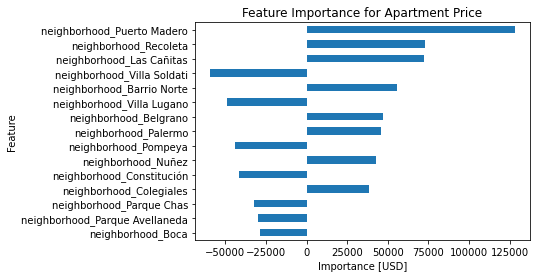

In [71]:
# Create a horizontal bar chart that shows the top 15 coefficients for my model, based on their absolute value
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");

Looking at this bar chart, I can see that the poshest neighborhoods in Buenos Aires like [Puerto Madero](https://en.wikipedia.org/wiki/Puerto_Madero) and [Recoleta](https://en.wikipedia.org/wiki/Recoleta,_Buenos_Aires) increase the predicted price of an apartment, while more working-class neighborhoods like [Villa Soldati](https://en.wikipedia.org/wiki/Villa_Soldati) and [Villa Lugano](https://en.wikipedia.org/wiki/Villa_Lugano) decrease the predicted price. 